参考：The Annotated Transformer

In [216]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [217]:
class EncoderDecoder(nn.Module):
    '''
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    '''
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        # 编码属于transformer的一部分，不应该由其他函数的外部传入
        # 在这里构造嵌入，是为了外部更好的替换嵌入，且放置在上层api中，降低学习者的学习负担
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src,src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        # src的形状是[batch_size, seq_len]，每个值代表一个词的索引
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [218]:
class Generator(nn.Module):
    # 完成最后的线性变换，将模型输出转换为词汇表的概率分布
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [219]:
def clones(module, N):
    "产生N个完全相同的网络层"
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [220]:

# 自定义LayerNorm
class LayerNorm(nn.Module):
    "Construct a layernorm module"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        # 定义两个可学习的参数，可能还会使用到pytorch的广播机制
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        # 防止分母为0
        self.eps = eps

    def forward(self, x):
        # 在最后一个维度上求均值和方差
        mean = x.mean(-1, keepdim=True)
        # 在最后一个维度求标准差
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [221]:
class Encoder(nn.Module):
    "完整的Encoder包含N层"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "每一层的输入是x和mask"
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [222]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    # 采用了回调函数的编程方法
    def forward(self, x, sublayer):
        # 进行层归一化后再通过注意力机制和前馈神经网络，然后再进行残差连接
        return x + self.dropout(sublayer(self.norm(x)))

In [223]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        # 需要两个残差连接和层归一化
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [224]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        # layer.size是dimension
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        # 最后补上一个LayerNorm
        return self.norm(x)

In [225]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        # 带掩码的自注意力机制
        self.self_attn = self_attn
        # 注意力机制
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        # 一个block有三个残差连接和层归一化，比encoder多一个
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # x是decoder的输出，作为query，memory是encoder的输出，作为key和value
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        # 最后一个是前馈神经网络
        return self.sublayer[2](x, self.feed_forward)

In [226]:
# 对于单层decoder中的self-attention子层，我们需要使用mask机制，以防止在当前位置关注到后面的位置。
# 这段代码用于创建一个掩码，屏蔽掉后续的位置。它的主要功能是生成一个上三角矩阵，其中 k=1 指定了从主对角线以上的部分为 1，其他部分为 0。
def subsequent_mask(size):
    # 一般size是序列的长度
    attn_shape = (1, size, size)
    # np.triu返回矩阵的上三角部分，k=0表示将主对角线和以上位置置为1，k=1表示将主对角线以上的位置置为1
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [227]:
def attention(query, key, value, mask=None, dropout=None):
    # 获得embedding的维度
    d_k = query.size(-1)
    # transpose是为了将最后两个维度交换，这样才能进行矩阵乘法
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        # mask是一个上三角矩阵，将mask为0的位置的分数置为负无穷
        # mask的维度是[1,1,tgt_len,tgt_len],先计算Q和K的乘积，然后mask掉无效的位置
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    # TODO 为什么要返回p_attn，这是因为在decoder中的src_attn中，我们需要将p_attn返回，以便于后续的可视化
    return torch.matmul(p_attn, value), p_attn

In [228]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        # linears是一个list，包含四个线性层,主要是为了得到Q,K,V
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            # 假设 mask 是一个形状为 (batch_size, seq_length) 的张量，使用 unsqueeze(1) 后，形状将变为 (batch_size, 1, seq_length)
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        # transpose可以使用permute来代替
        # 这里只会进行三次的线性变换
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        # contiguous 是 PyTorch 中的一个方法，用于返回一个连续内存中的张量副本。
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [229]:
# 在transformer中，前馈神经网络是一个全连接的神经网络，包含两个线性变换和一个激活函数，他在每一个块的多头注意力机制之后进行残差连接和层归一化之后调用，而且做完
# 前馈神经网络之后还要进行残差连接和层归一化
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    # 输入相同的维度，输出相同的维度，但是中间的维度可以不同 
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [230]:
class Embeddings(nn.Module):
    # vocab是词表的大小，d_model是embedding的维度
    # nn.Embedding是一个简单的查找表，用于存储每一个词的embedding，我们可以通过索引来查找对应的embedding
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [231]:
# 可以看到，我们在编写一个架构的时候，会将每个子结构使用nn.Module进行封装，然后在forward函数中调用这些子结构，这样可以使得代码更加清晰，同时也方便了后续的调用和复用
# p_{k,2i}=\sin\left(k/1000^{2i/d}\right)  k是位置，i是维度，d是embedding的维度
class PositionalEncoding(nn.Module):
    # max_len是最大编码长度，默认是5000
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # dropout是为了防止过拟合
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        # 提前计算位置编码可以减少训练时间和提高推理速度

        # pe是一个二维矩阵，第一维是位置，第二维是embedding的维度，即每一行是一个位置的embedding
        pe = torch.zeros(max_len, d_model)
        # 生成一个表示一个位置的列表
        position = torch.arange(0, max_len).unsqueeze(1)
        # 生成比例因子
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        # 使用了切片操作，将偶数列的位置编码计算sin，奇数列的位置编码计算cos
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # unsqueeze是为了增加一个维度，这样可以和embedding相加(batch_size,seq_len,d_model)
        pe = pe.unsqueeze(0)
        # 将pe注册为一个buffer，这样在保存模型的时候，pe不会被保存
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # 将位置编码加到embedding上
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [232]:
# src_vocab和tgt_vocab是源语言和目标语言的词表大小, N是encoder和decoder的层数，d_model是embedding的维度，d_ff是前馈神经网络的维度，h是多头注意力机制的头数
# 如果是机器翻译任务，src_vocab和tgt_vocab的大小是不一样的
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    # 提供一个深拷贝的方法
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [233]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            # 第一个维度是batch_size，第二个维度是序列长度
            # 去掉最后一个词（通常用于训练时输入解码器的序列）。
            self.trg = trg[:, :-1]
            # 去掉第一个词。模型要预测的就是从第二个词开始的序列。
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

            # trg.size(): torch.Size([30, 9])
            # trg_mask.size(): torch.Size([30, 9, 9])
            # ntokens: tensor(270)
    
    # 只有定义为静态方法，才能在init中调用
    @staticmethod
    def make_std_mask(tgt, pad):
        # 对每一个句子，生成一个上三角矩阵，unsqueeze(-2）在倒数第二个维度上增加一个维度
        tgt_mask = (tgt != pad).unsqueeze(-2)
        # subsequent_mask需要传入一个序列的长度，返回一个0上三角矩阵
        # 由于广播机制，那么tgt_mask的第二个维度会被扩展为tgt.size(-1)，即序列的长度，返回的subsequent_mask也会进行广播
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [234]:
# 运行一个epoch，一个epoch包含多个batch,一般会将所有数据都遍历一遍
def run_epoch(data_iter, model, loss_compute):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [235]:
# 用于动态调整批次大小（batch size）
# max_src_in_batch：当前批次中源序列（源语言）的最大长度，max_tgt_in_batch：当前批次中目标序列（目标语言）的最大长度
# 在该文件中这个函数没有用到
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [236]:
# 顶一个了学习率调度器
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        # 实际使用的优化器，
        self.optimizer = optimizer
        self._step = 0
        # 预热参数
        self.warmup = warmup
        # 一个调节学习率的乘数系数。这个值用于放大或缩小学习率的大小。
        self.factor = factor
        # 模型的维度大小
        self.model_size = model_size
        self._rate = 0

    # 每次调用step函数，学习率都会更新，并且步数+1，参数也会更新    
    def step(self):
        self._step += 1
        rate = self.rate()
        # 将学习率应用到优化器的参数组中 
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    # 负责计算学习率，基于当前的步数和预设参数。
    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))


# 为了方便使用，我们定义了一个函数，该函数接受模型作为输入，并返回一个NoamOpt实例。
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [237]:
class LabelSmoothing(nn.Module):
    # size：类别数量，表示有多少个可能的分类。
    # padding_idx：填充索引，用于标识输入序列中的填充部分（特别是在自然语言处理任务中），这些部分不会被用于计算损失。
    # smoothing：平滑因子，控制标签平滑的强度，通常是一个小的值（如 0.1）。平滑因子越大，目标分布越“平滑”。
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        # 使用KLDivLoss作为损失函数，size_average=False表示不对损失求平均
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        # 表示目标类别的分布中给目标类别赋予的概率
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        # 初始化一个用于存储平滑后的真实分布的变量。
        self.true_dist = None
        
    def forward(self, x, target):
        # x：模型的输出（通常是 log-softmax 的结果），形状为 [batch_size, num_classes]，表示每
        # target：真实的目标标签（通常是整数编码的类别），形状为 [batch_size]，表示每个样本的真实类别。
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        # 将所有元素置为平滑因子除以类别数量
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        # 将属于填充部分的部分的损失置为0，注意一行表示所有的类别，所以肯定包含了填充的类别
        true_dist[:, self.padding_idx] = 0
        # 返回目标类别向量中填充部分的索引
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            # 在批次的维度将padding的位置置为0
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

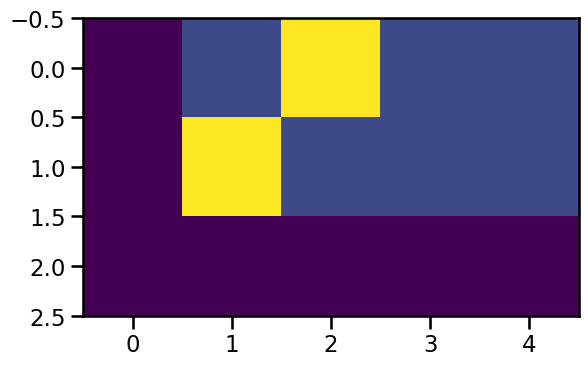

In [238]:
#Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None


In [239]:
print(crit.true_dist)

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


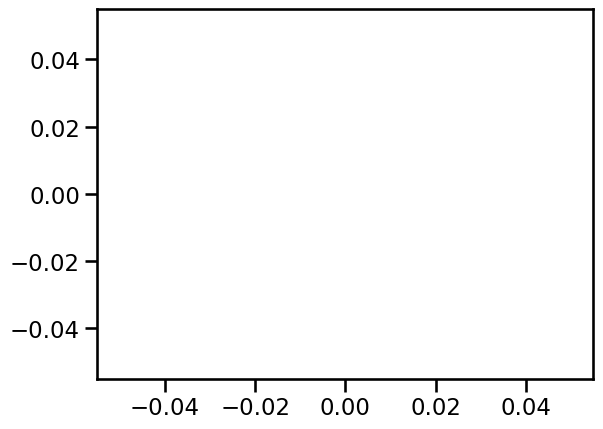

In [240]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).item()

y = [loss(x) for x in range(1, 100)]
x = np.arange(1, 100)
plt.plot(x, y)

In [241]:
# V：词汇表的大小（Vocabulary size），即在数据中每个元素的取值范围为 [1, V-1]。batch：每个批次（batch）中的样本数量。nbatches：生成的批次数量，即迭代的次数。
# data_gen(V, 30, 20)
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        # randint(low, high, size)：生成一个 [low, high) 范围内的整数，size 表示生成的随机数的形状。
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        # src和tgt是相同的数据，即输入和输出是一样的
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [242]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        # item函数是将一个标量Tensor转换为一个Python number
        return loss.item() * norm

In [243]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    # train会将所有子模块的training属性设置为True
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

/tmp/ipykernel_359/3025647527.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


Epoch Step: 1 Loss: 3.249415 Tokens per Sec: 1616.934448


Epoch Step: 1 Loss: 1.886713 Tokens per Sec: 2028.311523
tensor(1.8641)
Epoch Step: 1 Loss: 2.047898 Tokens per Sec: 1629.618896
Epoch Step: 1 Loss: 1.630408 Tokens per Sec: 1988.877808
tensor(1.6358)
Epoch Step: 1 Loss: 1.831577 Tokens per Sec: 1615.190918
Epoch Step: 1 Loss: 1.438090 Tokens per Sec: 2005.948242
tensor(1.4386)
Epoch Step: 1 Loss: 1.683892 Tokens per Sec: 1633.069824
Epoch Step: 1 Loss: 1.356744 Tokens per Sec: 2031.285645
tensor(1.3682)
Epoch Step: 1 Loss: 1.378142 Tokens per Sec: 1624.564697
Epoch Step: 1 Loss: 0.947862 Tokens per Sec: 2021.448730
tensor(0.9829)
Epoch Step: 1 Loss: 1.063265 Tokens per Sec: 1641.388550
Epoch Step: 1 Loss: 0.535661 Tokens per Sec: 2051.201172
tensor(0.5472)
Epoch Step: 1 Loss: 0.779421 Tokens per Sec: 1683.699341
Epoch Step: 1 Loss: 0.295361 Tokens per Sec: 2027.429077
tensor(0.2977)
Epoch Step: 1 Loss: 0.541436 Tokens per Sec: 1668.306152
Epoch Step: 1 Loss: 0.177185 Tokens per Sec: 1957.155518
tensor(0.2211)
Epoch Step: 1 Loss: 0.666

In [244]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  3,  5,  7,  8, 10, 10]])
